##  A 1-Hidden Layer Architecture
What is happening here?
    [1] A traditional ANN model.
    [2] Import and preprocessing data.
    [3] Trigonometric transformations, which converting the original angle plies into sine and cosine values range between -1 and 1 to helps normalize data.
    [4] Create a neural network model with specific hidden layer and the model uses the Sequential API from Keras, starting with an input layer, followed by a dense (fully connected) hidden layer with ReLU activation, and then an output layer with linear activation (for regression tasks).
    [5] Model Training and Evaluation: run over a range of different number of neurons (from 10 to 80 with step of 5) to tune the model's hyperparameters.
    For each number of neurons: A KerasRegressor wrapper is instantiated with the defined neural network model and training settings (epochs, batch size).
    5-Fold Cross-Validation for robust evaluates the model's performance metrics (MSE, MAE, R-squared) on each fold of the data and to avoid overfitting.
    [6] Model Evaluation (mean and standard deviation of performance metrics).
    [7] Plot Mean of(R2, MAE, RMSE) vs number of neurons.

Neurons: 10
Mean RMSE: 0.8135728445875386, Std RMSE: 0.27665359564747166
Mean MAE: 0.6215423362902041, Std MAE: 0.19508890158388692
Mean R-squared: 0.8793380491033453, Std R-squared: 0.07333887818687539
Neurons: 15
Mean RMSE: 0.7356705177937519, Std RMSE: 0.18141613030209777
Mean MAE: 0.588670362899874, Std MAE: 0.14633895686761036
Mean R-squared: 0.8969947922006014, Std R-squared: 0.061705769510099366
Neurons: 20
Mean RMSE: 0.49223141651719715, Std RMSE: 0.1326848644175316
Mean MAE: 0.3843772416012473, Std MAE: 0.12297793746640241
Mean R-squared: 0.9554488630029623, Std R-squared: 0.02614101588248665
Neurons: 25
Mean RMSE: 0.4869355518385149, Std RMSE: 0.06577877703606937
Mean MAE: 0.375578496214347, Std MAE: 0.04774741302114664
Mean R-squared: 0.96034285251915, Std R-squared: 0.00591194650256966
Neurons: 30
Mean RMSE: 0.6703608711437827, Std RMSE: 0.24022469616968833
Mean MAE: 0.5057108684453301, Std MAE: 0.1779788026978493
Mean R-squared: 0.9204412411919816, Std R-squared: 0.0440285

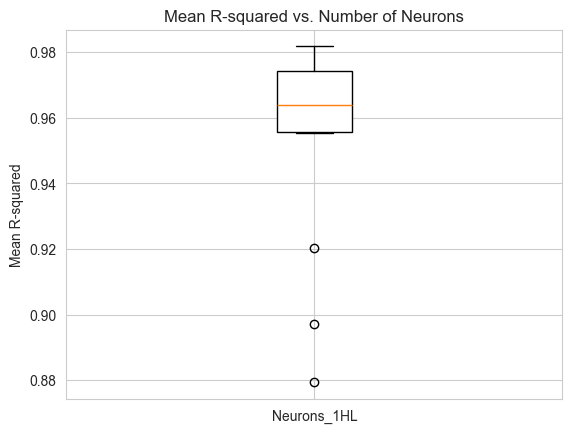

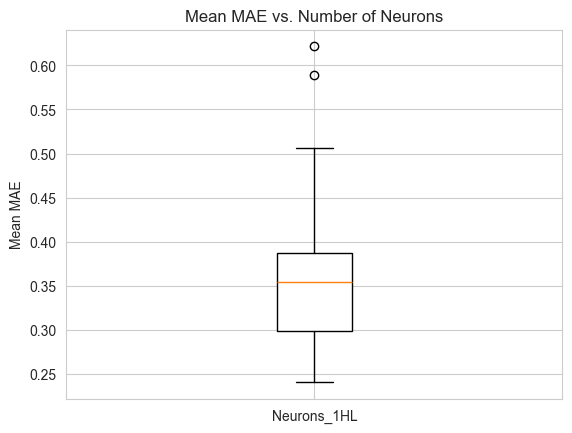

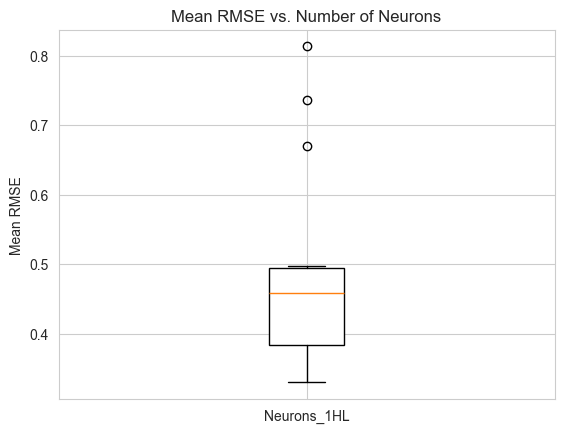

In [53]:
import pandas as pd 
import numpy as np                                             
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.base import TransformerMixin
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import KFold, cross_validate

## Import data
bucklingdata = pd.read_csv("CBL_SimulationResults.csv", encoding='cp1252')

## Convert the hole_column from integer into a floating data type
bucklingdata['Number of holes, nh'] = bucklingdata['Number of holes, nh'].astype('float64')
bucklingdata['Web opening diameter, Do (mm)'] = bucklingdata['Web opening diameter, Do (mm)'].astype('float64')

## Trigonometric transformation of the ply angles: We develop a trigonometric transformation function to convert the angles (this is important)
# Create a transformation class here for the angle plies:
class TrigonometricTransformer(TransformerMixin):
    def __init__(self, start_column=1, end_column=-1):
        self.start_column = start_column
        self.end_column = end_column
        self.transform_functions = [np.sin, np.cos]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        columns_to_transform = X.columns[self.start_column:self.end_column]

        for col in columns_to_transform:
            for func in self.transform_functions:
                X_transformed[col + '_' + func.__name__] = func(X[col])

        # Remove the original columns
        X_transformed.drop(columns=columns_to_transform, inplace=True)

        return X_transformed

# Specify the input and output datasets
input_data = bucklingdata.drop(['Critical Buckling Load (N)','Critical Buckling Load (kN)'], axis=1)
output_data = bucklingdata['Critical Buckling Load (kN)']

# Apply the transformation on the ply columns
transformer = TrigonometricTransformer(start_column=3, end_column=11)
# Transform the input DataFrame
transformed_bucklingdata = transformer.fit_transform(input_data)

# The input dimension for the Neural Network is then obtained as. Then, the input_size will use in following: model.add(Input(shape=(19,)))
input_size = transformed_bucklingdata.shape[1]
#print(input_size)

## Define a specific neural network model with one hidden layer
def create_model1H(hp_layer_1):
    model = Sequential()
    model.add(Input(shape=(19,)))
    model.add(Dense(hp_layer_1, activation='relu'))
    model.add(Dense(1, activation='linear'))
    hp_learning_rate = 0.01
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=['mae'])
    return model

# Pass the input and output dataframes to X , y (this is just convention in Python ML)
X = transformed_bucklingdata.copy()
y = output_data.copy()

neurons_list = np.arange(10, 85, 5)  # Define a list of different numbers of neurons

# Define lists to store results
results = []

# Define some empty list
for neurons in neurons_list:   
    # Create a KerasRegressor with the current number of neurons
    keras_regressor = KerasRegressor(model=lambda: create_model1H(neurons), epochs=150, batch_size=32, verbose=0)
    
    # Use cross_val_score to evaluate the model
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(keras_regressor, X, y, cv=kf,
                             scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'))
    mse_scores = -cv_results['test_neg_mean_squared_error']
    mae_scores = -cv_results['test_neg_mean_absolute_error']
    r2_scores = cv_results['test_r2']                           # R-squared scores are already positive
    
    # Print the mean and standard deviation of the scores
    print(f"Neurons: {neurons}")
    print(f"Mean RMSE: {np.sqrt(mse_scores).mean()}, Std RMSE: {np.sqrt(mse_scores).std()}")
    print(f"Mean MAE: {mae_scores.mean()}, Std MAE: {mae_scores.std()}")
    print(f"Mean R-squared: {r2_scores.mean()}, Std R-squared: {r2_scores.std()}")
    
    # Store the results
    results.append({
        'Neurons': neurons,
        'Mean RMSE': np.sqrt(mse_scores).mean(),
        'Std RMSE': np.sqrt(mse_scores).std(),
        'Mean MAE': mae_scores.mean(),
        'Std MAE': mae_scores.std(),
        'Mean R-squared': r2_scores.mean(),
        'Std R-squared': r2_scores.std()
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to an Excel file
results_df.to_excel('1HL_Neurons_Network_Results_KFold_CV.xlsx', index=False)
print()
print("------------Congrats! You have successfully save the results to 1HL_Neurons_Network_Results_KFold_CV------------")

## Plotting Performance Metrics Evaluation Graphs

In [ ]:
# Plot R-squared against neurons
plt.boxplot([results_df['Mean R-squared']], positions=[1], patch_artist=True, boxprops=dict(color='black', facecolor='white'), whiskerprops=dict(color='black'))
plt.xticks([1], ['Neurons_1HL'])
plt.ylabel('Mean R-squared')
plt.title('Mean R-squared vs. Number of Neurons')
plt.grid(True)
plt.show()

# Plot MAE against neurons
plt.boxplot([results_df['Mean MAE']], positions=[2], patch_artist=True, boxprops=dict(color='black', facecolor='white'), whiskerprops=dict(color='black'))
plt.xticks([2], ['Neurons_1HL'])
plt.ylabel('Mean MAE')
plt.title('Mean MAE vs. Number of Neurons')
plt.grid(True)
plt.show()

# Plot RMSE against neurons
plt.boxplot([results_df['Mean RMSE']],positions=[3], patch_artist=True, boxprops=dict(color='black', facecolor='white'), whiskerprops=dict(color='black'))
plt.xticks([3], ['Neurons_1HL'])
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE vs. Number of Neurons')
plt.grid(True)
plt.show()